# 3. Meshes for Surface Processes

This notebook introduces the `QuagMesh` object, which builds upon the `QuagMesh` and introduces methods for finding the stream connectivity, catchment identification and handling local minima.

Here we demonstrate the stream flow components of the `QuagMesh` 

> Note: Again, the API for the structured mesh is identical

In [1]:
from quagmire.tools import meshtools
from quagmire import QuagMesh, QuagMesh
from quagmire import function as fn

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.02, 0.02

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, random_scale=1.0)

DM = meshtools.create_DMPlex_from_points(x, y, bmask=None)

mesh   = QuagMesh(DM, downhill_neighbours=1)
meshn  = QuagMesh(DM, downhill_neighbours=1)  # A copy that we will use with a roughened topography 


print ("Triangulation has {} points".format(mesh.npoints))

Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.10814945799999975s
0 - Calculate node weights and area 0.010434500000000568s
0 - Find boundaries 0.007506959000000535s
0 - cKDTree 0.007003291000000189s
0 - Construct neighbour cloud arrays 0.24624329099999898s, (0.1655212499999994s + 0.08068958299999984s)
0 - Construct rbf weights 0.023653665999999518s
Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.11084924999999934s
0 - Calculate node weights and area 0.010404082999999176s
0 - Find boundaries 0.007980375000000706s
0 - cKDTree 0.007130709000000124s
0 - Construct neighbour cloud arrays 0.24403991700000027s, (0.16525795799999976s + 0.07875279199999952s)
0 - Construct rbf weights 0.021775334000000868s
Triangulation has 62234 points


## Height field and Rainfall

We generate the usual cylindrically symmetry domed surface and add multiple channels incised along the boundary. Here is it interesting to leave out the random noise to see how discretisation error influences the surface flow paths.

The `QuagMesh` stores a rainfall pattern that is used to compute the stream power assuming everything goes into the surface runoff it also records a sediment distribution pattern (etc).

In [4]:
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x) + 0.1

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(5.0*theta)**2 
height  += 0.5 * (1.0-0.2*radius)
heightn  = height + np.random.random(height.size) * 0.005 # random noise

with mesh.deform_topography():
    mesh.topography.data = height
        
with meshn.deform_topography():
    meshn.topography.data = heightn
    

0 - Build downhill matrices 1.0192250000000005s
0 - Build upstream areas 0.5904518340000013s
0 - Build downhill matrices 0.47453312500000067s
0 - Build upstream areas 0.5565477909999998s


In [5]:
rainfall = mesh.add_variable(name="Rainfall")
rainfall.data = (mesh.topography**2).evaluate(mesh)
mesh.cumulative_flow(rainfall.data)**2

array([5.03668335, 5.02298575, 5.01836541, ..., 2.66829351, 2.3281053 ,
       3.99135784])

In [6]:
(mesh.upstream_integral_fn((mesh.topography**2))**2).evaluate(mesh)

array([2.33382378e-05, 1.72046623e-05, 9.10228538e-06, ...,
       2.47019494e-06, 7.29065051e-06, 4.01484423e-06])

In [7]:
# rbf1  = mesh.build_rbf_smoother(1.0, 1)
# rbf01 = mesh.build_rbf_smoother(0.1, 1)
# rbf001 = mesh.build_rbf_smoother(0.01, 1)

# print(rbf1.smooth_fn(rainfall, iterations=1).evaluate(0.0,0.0))
# print(rbf01.smooth_fn(rainfall, iterations=1).evaluate(0.0,0.0))
# print(rbf001.smooth_fn(rainfall, iterations=1).evaluate(0.0,0.0))

In [8]:
# rbf001.smooth_fn(rainfall, iterations=1).evaluate(mesh)

In [9]:
rainfall.evaluate(mesh)

array([2.24425563, 2.24120185, 2.24017084, ..., 0.47308102, 0.42065372,
       0.36434709])

In [23]:
(meshn.topography**2).evaluate(mesh) # slightly different

array([2.24583735, 2.25110091, 2.24041793, ..., 0.47503408, 0.42540432,
       0.36483562])

## Upstream area and stream power

Integrating information upstream is a key component of stream power laws that are often used in landscape evolution models. This is computed by multiple $\mathbf{D} \cdot \mathbf{A}_{\mathrm{upstream}}$ evaluations to accumulate the area downstream node-by-node on the mesh. 

A `QuagMesh` object has a cumulative_flow method that computes this operation. There is also a quagmire function wrapper of this method that can be used as an operator to compute the area-weighted sum. This function is the numerical approximation of the upstream integral:

```python
upstream_precipitation_integral_fn = mesh.upstream_integral_fn(rainfall_pattern)
```



<!--
NOTE: rbf_smooth / streamwise_smooth need to be a function on the mesh ... 


This is handled by the `cumulative_flow(vector)` routine.

In [derivatives and hill slopes](#Derivatives-and-hill-slopes) we smoothed the entire landscape, however we can also target the RBF kernel to smooth just the streams:

```python
streamwise_smoothing(data, its, centre_weight=0.75)
```

where `its` indicates the number of iterations to smooth the field stream-wise. Increasing `its` smooths the field further afield upstream and downstream.
-->

In [10]:
rainfall_fn = (mesh.topography**2.0)
upstream_precipitation_integral_fn = mesh.upstream_integral_fn(rainfall_fn)
stream_power_fn = upstream_precipitation_integral_fn**2 * mesh.slope**1.0 * mesh.mask

stream_power_fn.evaluate(mesh)

array([1.01149038e-06, 1.42140223e-06, 7.31194445e-07, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

#### Tools: stream power smoothing

It may be that some smoothing is helpful in stabilizing the effect of the stream power term in the topography evolution equation. The following examples may be helpful.

Note that we provide an operator called `streamwise_smoothing_fn` which is conservative, a centre weighted smoothing kernel that only operates on nodes that are connected to each other in the stream network.

In [11]:
## We can apply some smoothing to this if necessary

rbf_smoother = mesh.build_rbf_smoother(0.1, 1)
rbf_smooth_str_power_fn = rbf_smoother.smooth_fn(stream_power_fn)
print(rbf_smooth_str_power_fn.evaluate(mesh))

str_smooth_str_power_fn = mesh.streamwise_smoothing_fn(stream_power_fn)
print(str_smooth_str_power_fn.evaluate(mesh))

[4.92762608e-06 5.05863511e-06 5.90557871e-06 ... 1.03472052e-05
 1.40392478e-05 2.45570950e-05]
(array([2.4806877e-06, 2.3550435e-06, 1.4648087e-06, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), array([0, 0, 0, ..., 0, 0, 0], dtype=int32))


In [12]:
## We could also smooth the components that make up the stream power

rbf_smoothed_slope_fn = rbf_smoother.smooth_fn(mesh.slope)
rbf_smooth_str_power_fn2 = upstream_precipitation_integral_fn**2 * rbf_smoothed_slope_fn**1.0 * mesh.mask
print(rbf_smooth_str_power_fn2.evaluate(mesh))

str_smoothed_slope_fn = mesh.streamwise_smoothing_fn(mesh.slope)
str_smooth_str_power_fn2 = upstream_precipitation_integral_fn**2 * str_smoothed_slope_fn**1.0 * mesh.mask
print(str_smooth_str_power_fn2.evaluate(mesh))

[2.20452134e-06 1.63820484e-06 8.61642731e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.18953900e-06 1.46293268e-06 7.58957690e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [25]:
colorby_1 = stream_power_fn.evaluate(mesh).astype(np.float32)
colorby_2 = rbf_smooth_str_power_fn.evaluate(mesh).astype(np.float32)
colorby_3 = str_smooth_str_power_fn.evaluate(mesh)[0].astype(np.float32)

AttributeError: 'tuple' object has no attribute 'astype'

In [27]:
str_smooth_str_power_fn.evaluate(mesh)[0]

array([2.4806877e-06, 2.3550435e-06, 1.4648087e-06, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [ ]:
import k3d

plot = k3d.plot(grid_visible=False, lighting=0.75)
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack([mesh.tri.points, height]).astype(np.float32)

plot += k3d.mesh(points+(00.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_1,
                    color_range = [0.0,1.0]
                   )



plot += k3d.mesh(points+(15.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_2,
                    color_range = [0.0,1.0]

                   )

plot += k3d.mesh(points+(30.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_3,
                    color_range = [0.0,1.0]

                   )

plot.display()

## Outflow analysis

The topography we have defined has multiple outflow points, which, in the analytic case, should be equal. If they differ, this is a result of the discretisation. 

When we introduce random noise we also (usually) introduce some internal low points in the mesh that capture some of the surface flow.

In [15]:
outflow_nodes = mesh.identify_outflow_points()
low_point_nodes = mesh.identify_low_points()
cumulative_rain = mesh.upstream_integral_fn(rainfall_fn).evaluate(mesh)
outflow_std_mesh = cumulative_rain[outflow_nodes]

print("{} outflow nodes:".format(len(outflow_nodes)))
print(outflow_nodes)
print("{} internal low point nodes:".format(len(low_point_nodes)))
print(outflow_nodes)
print(outflow_std_mesh)

outflow_standard_mesh = cumulative_rain[outflow_nodes]


# --- 


    
cumulative_rain_n = meshn.upstream_integral_fn(rainfall_fn).evaluate(meshn)
outflow_nodes = meshn.identify_outflow_points()
low_point_nodes = meshn.identify_low_points()
outflow_rough_mesh = cumulative_rain_n[outflow_nodes]
cumulative_flow_rough_mesh = cumulative_rain_n[np.hstack((outflow_nodes, low_point_nodes))]

print("{} outflow nodes:".format(len(outflow_nodes)))
print(outflow_nodes)
print("{} internal low point nodes:".format(len(meshn.identify_low_points())))
print(low_point_nodes)
print(outflow_rough_mesh)

18 outflow nodes:
[61753 61803 61853 61902 61903 61952 61953 61954 61955 62002 62052 62102
 62151 62152 62201 62202 62203 62204]
0 internal low point nodes:
[61753 61803 61853 61902 61903 61952 61953 61954 61955 62002 62052 62102
 62151 62152 62201 62202 62203 62204]
[1.35633608e+00 2.91068294e+00 6.94590720e+00 3.80703311e+00
 1.25669386e-01 1.76046638e+00 8.94107460e-04 5.28614675e-02
 4.44502805e-02 1.79498622e+00 4.04115816e+00 6.07827447e+00
 3.67500277e+00 1.27469995e-01 1.74984466e+00 1.25728405e-04
 6.31638902e-02 1.78825614e-04]
19 outflow nodes:
[61753 61754 61803 61852 61902 61904 61952 61954 61955 61956 62002 62052
 62053 62102 62151 62152 62201 62202 62204]
103 internal low point nodes:
[15115 15585 16959 17428 17551 17568 17578 17617 17750 18259 18328 18339
 18341 18367 18478 18505 18559 18643 18759 18776 19358 19439 19487 19495
 19608 19635 19692 19834 19859 19948 20029 20089 20200 20226 20229 20371
 20444 20454 20483 20600 20831 21208 21432 21456 21471 21530 21707 21973

In [16]:
print(outflow_standard_mesh.sum())
print(outflow_rough_mesh.sum())
print(cumulative_flow_rough_mesh.sum())

34.534505676164535
23.056012399787203
30.904065177114536


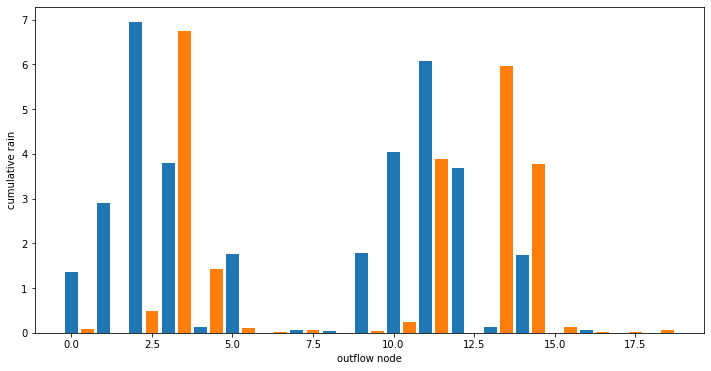

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot bar graph of cumulative rain for each outflow point

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111, xlabel='outflow node', ylabel='cumulative rain')
ax1.bar(np.array(range(0,len(outflow_std_mesh))), width=0.4, height=outflow_std_mesh)
ax1.bar(np.array(range(0,len(outflow_rough_mesh)))+0.5, width=0.4, height=outflow_rough_mesh)
plt.show()

In [18]:
rainfall_n_fn = (mesh.topography**2.0)
upstream_precipitation_integral_n_fn = meshn.upstream_integral_fn(rainfall_n_fn)
stream_power_n_fn = upstream_precipitation_integral_n_fn**2 * meshn.slope**1.0 * meshn.mask

colorby_2 = stream_power_n_fn.evaluate(meshn)


In [19]:
import k3d

plot = k3d.plot(grid_visible=False, lighting=0.75)
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack([mesh.tri.points, height]).astype(np.float32)

plot += k3d.mesh(points+(00.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_1,
                    color_range = [0.0,1.0]
                   )

points  = np.column_stack([meshn.tri.points, heightn]).astype(np.float32)

plot += k3d.mesh(points+(15.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_2,
                    color_range = [0.0,1.0]

                   )

plot.display()

Output()

Note that the mesh with random noise also has a number of internal low points that do not drain to the outside of the mesh. This is a non-physical aspect of the mesh that we would normally fix and is dealt with in a later notebook. 

Downhill transport matrices are introduced in the next example, [Ex4-Multiple-downhill-pathways](./Ex4-Multiple-downhill-pathways.md) and then we will discuss the infilling of local minima in Example 5.